# Exploring TC PRIMED, Chapter 3: Pixel-Based Neural Network Application
- Creators: Naufal Razin, Kathy Haynes, and Chris Slocum
- Affiliation: CIRA and NESDIS/STAR
- History: August 15th, 2024: Modified for TC PRIMED v01r01

---

## Overview
TC PRIMED contains passive microwave observations in their original swath structure. One of the ways in which users can apply a machine learning method to TC PRIMED swath data is by training a machine learning model for individual pixels. In this notebook, we will explore one way to pre-process TC PRIMED passive microwave data and apply a pixel-based machine learning method.

## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:
- the basics of Python programming such as loading modules, assigning variables, and list/array indexing
- NetCDF files and NetCDF groups (Chapter 1a of this Learning Journey)
- plotting data using `matplotlib`
- TC PRIMED overpass file data structure (Chapter 1b of this Learning Journey)
- basic performance metrics like mean squared error and mean absolute error

## Learning Outcomes
By working through this notebook, you will learn how to:
- develop a pre-processing step for TC PRIMED passive microwave data for a pixel-based machine learning application
- apply a pixel-based machine learning method to TC PRIMED passive microwave data

## Time Estimate
- Estimated text reading time: 15 to 29 min
- Estimated code reading time: 11 to 21 min
- Estimated total reading time: 26 to 50 min

## Background
The Tropical Cyclone Precipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED) is a dataset centered around satellite passive microwave observations of tropical cyclones. TC PRIMED contains data from consistent sources, making it suitable for machine learning applications. For example, the passive microwave brightness temperature data in TC PRIMED has been corrected for any instrument drift and bias such that the observed brightness temperatures are consistent throughout the multiple years each satellite has been in orbit (Berg et al. 2016). Therefore, the differences in observed brightness temperatures are mainly due to differences in the characteristics of the different sensors in TC PRIMED.

When developing any machine learning model, your dataset would usually consist of input feature(s) and target label(s). The input feature(s) is the input you would use to make your prediction and the target label(s) is what you want to predict. Since TC PRIMED stores passive microwave brightness temperature data in its original swath format, users can take one of two approaches to apply a machine learning model to the TC PRIMED swath data:
- process the swath data (like brightness temperature) into a more uniform data structure and use that as the input feature to predict a storm-scale phenomenon (the target label, e.g., is there a hurricane eye in the passive microwave image?)
- make pixel-based predictions by using the brightness temperature values at each pixel as the input feature to predict the target label within the same pixel (e.g., is there convective or stratiform precipitation in the passive microwave pixel?)

In this notebook, we will go through an example of the second approach. And, in contrast to the *classification* examples provided above, we will employ a machine learning *regression*. In particular, we will use passive microwave brightness temperature observations from the Global Precipitation Measurement mission (GPM) satellite's Microwave Imager (GMI) sensor as our input feature to predict/regress the target label, which we have chosen to be the surface precipitation rate, at each pixel. Using GMI observations simplifies our example since:
- it makes observations using a conical-scanning sensor, which ensures a constant resolution across the swath
- its observations in the 10.65 GHz through 89.0 GHz frequencies are located on the same swath

For our surface precipitation rate, we will use the NASA Goddard PROFiling algorithm (GPROF; Kummerow et al. 2015), also included in TC PRIMED. GPROF contains a surface precipitation rate variable that is available on the same swath as the passive microwave observations in the 10.65 through 89.0 GHz frequencies. The GPROF surface precipitation rate variable is in a unit of mm/hour.

To recap, we will use the GPM passive microwave observations as our input features to predict/regress the surface precipitation rate at each pixel using GPROF as our target label. Note, however, GPROF uses a Bayesian approach, ancillary data such as reanalysis fields, and the passive microwave brightness temperature observations to obtain a precipitation profile within the passive microwave pixel. Therefore, **GPROF is not completely independent from the passive microwave observations.** We are simply using GPROF in this example to avoid additional layers of data pre-processing. Users can use their own independent dataset for a pixel-based prediction by regridding the dataset (e.g., observation from the GPM dual-frequency precipitation radar) onto the passive microwave swath. Figure 1 shows an example of the passive microwave brightness temperature observations and GPROF surface precipitation rate from Hurricane Irma (2017).

<figure>
<img alt="Hurricane Irma (2017) overpass showing brightness temperatures and NASA Goddard PROFiling algorithm surface precipitation rates from a GPM." src="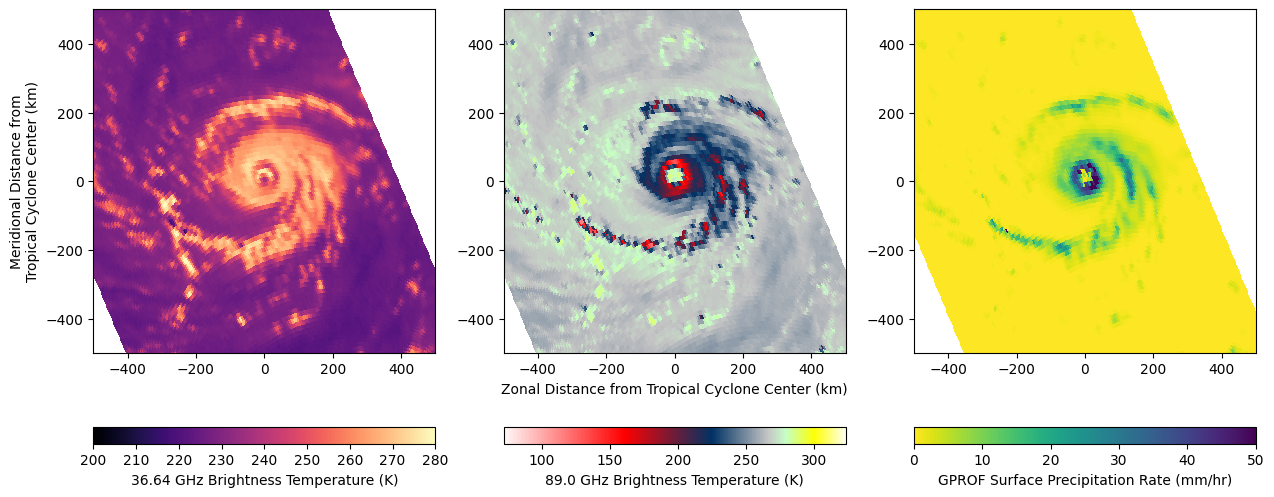" width="900">

<figcaption align = "center"><b>Figure 1.</b> Example of 36.64 GHz and 89.0 GHz brightness temperatures with GPROF surface precipitation rates from a GPM observation of Hurricane Irma (2017).</figcaption>
    
</figure>

## Software
This tutorial uses the Python programming language and packages. We will use:
- `netCDF4` to read in the TC PRIMED file
- `numpy` for simple array operations
- `tensorflow` for artificial neural network operations
- `matplotlib` to plot the data

### Install Packages
Let's first check if we have the necessary Python packages to run this notebook. If we don't, let's install them.

In [ ]:
import subprocess, sys
packages = ["netCDF4", "matplotlib",
            "numpy", "tensorflow"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now, let's load the modules in the packages (e.g., `Dataset`) or load the packages and assign a shorter object name for the packages (e.g., `import numpy as np`) for a cleaner use throughout the notebook.

In [ ]:
from netCDF4 import Dataset
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'

## Splitting Data Into Training, Validation, and Testing Sets
As we have mentioned in the [background](#Background), your dataset would usually consist of input feature(s) and target label(s). To develop a good machine learning model, this pair of input feature(s) and target label(s) should also be separated into [training, validation, and testing sets](https://mlu-explain.github.io/train-test-validation/). In essence:
- The training set is the dataset you would use to train your model.
- The validation set is the dataset you would use to validate the performance of your trained model. By assessing the performance of the trained model on your validation set, you could decide to tweak the model hyperparameters to try to increase the model skill and/or reduce effects of underfitting or overfitting.
- The testing set is the dataset used to evaluate the final model. The testing set should be completely independent from the training and validation process. **Only evaluate the model on the testing set as a final step, once you are happy with your model performance based on the validation set.**

Typically, the training set encompasses 60% - 80% of your overall data, while the validation set encompasses 20% - 30% of your data. Equally important, the training, validation, and testing sets should not be from the same sample. In other words, if you want your model to predict tropical cyclone intensification and you use the intensity data from Hurricane Michael to train your model, neither your validation nor testing sets should have any intensity data from Hurricane Michael.

With these criteria in mind, let's obtain the training, validation, and testing sets from TC PRIMED. When developing a machine learning model, we typically would want to maximize the number of samples that we use. However, for this notebook, we will use only a subset of TC PRIMED data for computing efficiency. Therefore,
- for the training set, we will use a select few GPM observations from Hurricane Jose (2017).
- for the validation set, we will use a select few GPM observations from Hurricane Maria (2017).
- for the testing set, we will use select a few GPM observations from Hurricane Irma (2017)

## Read Files Online
Let's retrieve information from the TC PRIMED files that we will use in this example, for the storms that we have listed above. We will use the Python `netCDF4` and `requests` packages to read and retrieve the information directly from the TC PRIMED file available on an Amazon Web Service S3 bucket as part of the NOAA Open Data Dissemination program (NODD), without downloading the file, and store the information from the file in an "instance" type called `DS`.

In [ ]:
import requests

# Specify the URL to the Jose TC PRIMED folder on NODD
TRAIN_NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r01/final/2017/AL/12/"

# Specify the names of the files we will use from the Jose TC PRIMED folder on NODD
TRAIN_FILE_NAMES = [
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020015_20170906043445.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020053_20170908155053.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020062_20170909050741.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020084_20170910153816.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020093_20170911045828.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020124_20170913044940.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020130_20170913143556.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020139_20170914035721.nc",
    "TCPRIMED_v01r01-final_AL122017_GMI_GPM_020170_20170916034806.nc"
                   ]

# Declare TRAIN_DS as a dictionary
TRAIN_DS = {}

# Loop through each train file name
for train_file_name in TRAIN_FILE_NAMES:

    # Join TRAIN_NODD_URL and train_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    url_response = requests.get(TRAIN_NODD_URL + train_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary TRAIN_DS with the file name as the dictionary key
    TRAIN_DS[train_file_name] = Dataset(train_file_name, memory=url_response.content)

In [ ]:
# Specify the URL to the Maria TC PRIMED folder on NODD
VAL_NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r01/final/2017/AL/15/"

# Specify the names of the files we will use from the Maria TC PRIMED folder on NODD
VAL_FILE_NAMES = [
    "TCPRIMED_v01r01-final_AL152017_GMI_GPM_020200_20170918020233.nc",
    "TCPRIMED_v01r01-final_AL152017_GMI_GPM_020253_20170921122621.nc",
    "TCPRIMED_v01r01-final_AL152017_GMI_GPM_020284_20170923121507.nc",
    "TCPRIMED_v01r01-final_AL152017_GMI_GPM_020345_20170927101954.nc",
                 ]

# Declare VAL_DS as a dictionary
VAL_DS = {}

# Loop through each val file name
for val_file_name in VAL_FILE_NAMES:

    # Join VAL_NODD_URL and val_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    url_response = requests.get(VAL_NODD_URL + val_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary VAL_DS with the file name as the dictionary key
    VAL_DS[val_file_name] = Dataset(val_file_name, memory=url_response.content)

In [ ]:
# Specify the URL to the Irma TC PRIMED folder on NODD
TEST_NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r01/final/2017/AL/11/"

# Specify the names of the files we will use from the Irma TC PRIMED folder on NODD
TEST_FILE_NAMES = [
    "TCPRIMED_v01r01-final_AL112017_GMI_GPM_019929_20170831162933.nc",
    "TCPRIMED_v01r01-final_AL112017_GMI_GPM_019938_20170901054652.nc",
    "TCPRIMED_v01r01-final_AL112017_GMI_GPM_020007_20170905165142.nc",
    "TCPRIMED_v01r01-final_AL112017_GMI_GPM_020038_20170907164046.nc",
                  ]

# Declare TEST_DS as a dictionary
TEST_DS = {}

# Loop through each test file name
for test_file_name in TEST_FILE_NAMES:

    # Join TEST_NODD_URL and test_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    url_response = requests.get(TEST_NODD_URL + test_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary VAL_DS with the file name as the dictionary key
    TEST_DS[test_file_name] = Dataset(test_file_name, memory=url_response.content)

## Data Pre-Processing: Generating Input Features and Target Labels
Recall again that we want to predict the surface precipitation rate at each passive microwave pixel. To select the input features and target label, we have to be mindful of two things:
- Land surfaces have varying microwave brightness temperature signatures due to varying land surface types. The subset of observations we have selected above is not big enough to sufficiently capture all the possible surface types, which would affect our model's ability to make predictions. Therefore, for this notebook, we will focus our model on predicting the surface precipitation rates over the more homogeneous ocean surface.
- The passive microwave brightness temperature fields and GPROF surface precipitation rate field may have masked values. When training the model, we must exclude the masked values and only train the model when the selected passive microwave brightness temperature fields *and* the GPROF surface precipitation rate fields contain valid, non-masked values.

The following points outline the steps we will have to take to pre-process TC PRIMED data to generate the input features and target label:
- load the appropriate passive microwave brightness temperature fields as our input features
- load the surface type variable included in TC PRIMED for the passive microwave brightness temperature fields, which identifies whether the pixel is located over the land or the ocean
- load the GPROF surface precipitation field as our target label
- find the pixels over the ocean that have valid, non-masked values for **all** our input features and target label
- combine the input features and target label from all TC PRIMED files into their respective input features and target label arrays

We incorporate these steps into a function below. If you wish to understand how to properly pre-process TC PRIMED data into pixel-based input features and target labels, understanding the function is crucial.

In [ ]:
def generate_features_and_labels(FILE_DICT, FILE_NAMES, frequencies):
    """
    Generate input features and target labels from a set of TC PRIMED GPM
    overpass files

    Parameters
    ----------
    FILE_DICT : dictionary
        dictionary containing the NetCDF instances for each file in FILE_NAMES
    FILE_NAMES: array-like
        list of TC PRIMED GPM file names from which we want to generate the input
        features and target labels
    frequencies : array-like
        list of GPM observation frequencies we want to use as the input
        features

    Returns
    -------
    features : array-like
        array of passive microwave brightness temperatures at each pixel as
        our input features
    labels : array-like
        array of GPROF surface precipitation rate at each pixel as our target
        labels
    """
    # Value to replace masked data and to ignore when generating input
    # features and target labels
    _FillValue = -999.0

    # Since we don't usually know the size of our sample, we will generate an
    # empty array and continuously append values

    # Generate a dictionary of emtpy array to store brightness temperature
    # values for each observing frequency.
    feature_lists = {}
    for frequency in frequencies:
        feature_lists[frequency] = np.array([])

    # Generate empty array to store GPROF surface precipitation rate
    labels = np.array([])

    # Loop through each TC PRIMED GPM file
    for FILE_NAME in FILE_NAMES:

        # Load the latitude and longitude values of the observation pixels
        # and their corresponding surface type (a.k.a. land/ocean mask)
        latitude = FILE_DICT[FILE_NAME]["passive_microwave/S1/latitude"][:]
        longitude = FILE_DICT[FILE_NAME]["passive_microwave/S1/longitude"][:]
        surface_type = FILE_DICT[FILE_NAME]["passive_microwave/S1/surface_type"][:]

        # Load the surface precipitation rate from GPROF
        # Replace the masked value with the specified _FillValue
        surfaceprecip = FILE_DICT[FILE_NAME]["GPROF/S1/surfacePrecipitation"][:].filled(_FillValue)

        # Find the indices of the pixels that are over the ocean
        # In TC PRIMED, ocean and lake surfaces have a flag value of 0
        select_idx = np.argwhere(surface_type == 0)

        # Find the indices of the GPROF surface precipitation rate with a valid
        # value that is not the _FillValue. Append the indices to the indices of
        # pixels over the ocean
        select_idx = np.append(select_idx, np.argwhere(surfaceprecip != _FillValue), axis=0)

        # Find all unique indices
        # Select the unique indices only if there are more than one in the
        # original array (indicating an overlap between the indices for pixels
        # over the ocean and GPROF pixels that are not _FillValue)
        unique_idx, count_idx = np.unique(select_idx, axis=0, return_counts=True)
        select_idx = unique_idx[count_idx > 1]

        # Initialize dictionary to store brightness temperature fields
        TB = {}

        # Loop through each observation frequency we want to use as our
        # input feature
        for frequency in frequencies:

            # Load the brightness temperature field
            # Replace the masked value with the specified _FillValue
            TB[frequency] = FILE_DICT[FILE_NAME]["passive_microwave/S1/TB_" + frequency][:].filled(_FillValue)

            # Append indices of brightness temperature values that are not
            # _FillValue to the indices we have already selected above
            select_idx = np.append(select_idx, np.argwhere(TB[frequency] != _FillValue), axis=0)

            # Repeat the steps above
            # Iteratively select indices for pixels that are over the ocean,
            # have GPROF pixels that are not _FillValue, have brightness
            # temperature pixels that are not _FillValue, etc.
            unique_idx, count_idx = np.unique(select_idx, axis=0, return_counts=True)
            select_idx = unique_idx[count_idx > 1]

        # Loop through each index we have selected
        for idx in select_idx:

            # Append the value of GPROF surface precipitation rate into our
            # target label array
            labels = np.append(labels, surfaceprecip[idx[0],idx[1]])

            # Loop through each observation frequency
            for frequency in frequencies:

                # Append the value of the brightness temperature into our
                # input feature array
                feature_lists[frequency] = np.append(feature_lists[frequency], TB[frequency][idx[0],idx[1]])

    # Now, convert dictionary of input feature arrays into a 2-D array
    # of input features
    for frequency in frequencies:

        if frequency == frequencies[0]:

            features = feature_lists[frequency]

        else:

            features = np.vstack((features, feature_lists[frequency]))

    return np.transpose(features), labels

## Data Pre-Processing: Feature Selection
Now that we have a function to generate our input features and target labels, let's generate the input features and target labels for our training, validation, and testing sets. During this process, we need to apply our understanding of the physical processes behind our dataset. Our target label is the surface precipitation rate. In order to predict our target label with some skill, we must use the input features that would provide the best information to make the prediction.

For example, if we want to predict the maximum daily temperature at any time of the year, one of our input features may be the daily minimum solar zenith angle. Low solar zenith angle means that the sun is almost directly overhead. Therefore, the intensity of solar radiation would be stronger and we can expect the maximum daily temperature to be higher. The relationship between the daily minimum solar zenith angle and the maximum daily temperature is based on solid physical understanding of the system we want to predict, and should lead to a machine learning model with some skill. However, if we use a different input feature that is not based on solid physical understanding of the factors that affect the maximum daily temperature &mdash; say, the number of times your cat pushes your cup off of your coffee table in a day &mdash; then our model will not have any skill.

NASA briefly describes how the [different GMI observation frequencies](https://gpm.nasa.gov/missions/GPM/GMI) relate to the different types of atmospheric processes. The following list shows the GMI observation frequencies we can use in this notebook:
- 10.65V
- 10.65H
- 18.7V
- 18.7H
- 23.8V
- 36.64V
- 36.64H
- 89.0V
- 89.0H

To start, let's use the 36.64 GHz and 89.0 GHz observation frequencies as our input features. The 89.0 GHz observation frequency is sensitive to the scattering of Earth radiation by large precipitation-sized ice particles in deep convection. The 36.64 GHz observation frequency is generally sensitive to emission of radiation by liquid precipitation, but can also be affected by scattering processes of large ice particles.

In [ ]:
frequencies = ["36.64V", "36.64H", "89.0V", "89.0H"]

Generate input features and target labels for our trainining, validation, and input sets. **These will take a minute or two to run.**

In [ ]:
train_features, train_labels = generate_features_and_labels(TRAIN_DS, TRAIN_FILE_NAMES, frequencies)

In [ ]:
val_features, val_labels = generate_features_and_labels(VAL_DS, VAL_FILE_NAMES, frequencies)

In [ ]:
test_features, test_labels = generate_features_and_labels(TEST_DS, TEST_FILE_NAMES, frequencies)

## About the Machine Learning Model: The Artificial Neural Network
Here, we provide a basic description of the [artificial neural network](https://www.ibm.com/topics/neural-networks). In *very* simplified terms, the artificial neural network is similar to linear regression but with additional non-linear steps. Let's briefly take a look at the linear regression as an analogy. A linear regression model takes the form of:
$$y = mx + b$$
Where $y$ is your predicted value, $x$ is your input value, $m$ is the weight, and $b$ is the bias. Now, let's say you have an artificial neural network model with two hidden layers. In the first hidden layer, the model takes the input values ($x$) and generates multiple subsets of linear regression models that each produce a predicted value ($y$). The number of linear regression models depends on the number of nodes in the first hidden layer, which is specified by the user. At this point, the model adds non-linearity by applying an activation function to the predicted values from the first hidden layer. This activation function is also specified by the user.

After the activation function is applied to the predicted values from the first hidden layer, the predicted values become the input values for the next hidden layer, and the process repeats. In the final layer, no activation function is applied and the model linearly regresses the predicted values from the last hidden layer to the target label. During training, the artificial neural network finds the weight ($m$) and bias ($b$) values for each subset of linear regression models by minimizing a loss function (e.g., mean squared error).

From the basic description of the artificial neural network model above, you have a few basic [model hyperparameters](https://www.youtube.com/watch?v=h291CuASDno) to choose:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function
- the loss function

In addition, there are a few other hyperparameters that we did not discuss, but still need to be selected:
- the optimizer, which is a function that determines how the weights and biases are modified
- the batch size, which tells the model how many samples from the full training set the model should train on before updating the weights and biases
- the number of epochs, which tells the model how many times to train the model using the full training set

## But, Wait!
The range of values for our data may vary by the data type. For our input features, brightness temperatures in the 89.0 GHz observation frequency may have a larger spread of possible values (for example, from 50 to 310 K) compared to the brightness temperature in the 36.64 GHz observation frequency. The large range of values in the data, and the varying range of values between the data types, can influence the [speed and stability of our model training](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/), particularly for deep learning neural networks (as opposed to, say, a random forest model). Therefore, there is one additional pre-processing step that we have to take.

## Data Pre-Processing: Normalizing the Input Data
There are several ways in which we can compress the large range of values in our data and put them onto the same scale. The two most common ways are normalizing or standardizing our data. In this notebook, we will normalize our *input features* before we feed them to our model. Data normalization takes the form of:
$$ x' = \frac{x -  min(x)}{max(x) - min(x)}$$
Here, $x'$ is the normalized value of $x$, and $min(x)$ and $max(x)$ are the respective minimum value and maximum value of $x$. By normalizing the data, we constrain the values of each of our input features to be between zero and one. Typically, the values of $min(x)$ and $max(x)$ come from domain knowledge. But, in this notebook, we will simply obtain them from the training, validation, and testing sets. Let's generate a function to obtain the minimum and maximum values for *each* of our input features.

In [ ]:
def obtain_feature_min_max(frequencies, train_features, val_features, test_features):
    """
    Obtain min and max values of input features from the training, validation,
    and testing sets

    Parameters
    ----------
    frequencies : array-like
        list of GPM observation frequencies we want to use as the input
        features
    train_features : array-like
        2-D array of input features from the training set
    val_features : array-like
        2-D array of input features from the validation set
    test_features : array-like
        2-D array of input features from the testing set

    Returns
    -------
    feature_min : dict
        dictionary containing the minimum value of each observation frequency
        in the input features
    feature_max : dict
        dictionary containing the maximum value of each observation frequency
        in the input features
    """

    feature_min = {}
    feature_max = {}

    for freq_idx, frequency in enumerate(frequencies):

        all_features = np.hstack((train_features[:,freq_idx],
                                  val_features[:,freq_idx],
                                  test_features[:,freq_idx]))

        feature_min[frequency] = np.min(all_features)
        feature_max[frequency] = np.max(all_features)

    return feature_min, feature_max

Let's obtain the minimum and maximum values of each of our input features using the function we have generated. Then, let's just look at the range of values of the input features.

In [ ]:
feature_min, feature_max = obtain_feature_min_max(frequencies, train_features, val_features, test_features)

for frequency in frequencies:

    print("Observation frequency: ", frequency)
    print("Minimum value: ", feature_min[frequency])
    print("Maximum value: ", feature_max[frequency])
    print(" ")

Now that we have the minimum and maximum value for each input feature, let's generate a function to normalize the input feature.

In [ ]:
def normalize_input_features(frequencies, input_features, feature_min, feature_max):
    """
    Normalize input features

    Parameters
    ----------
    frequencies : array-like
        list of GPM observation frequencies we want to use as the input
        features
    input_features : array-like
        2-D array of input features
    feature_min : dict
        dictionary containing minimum value for each observing frequency
    feature_max : dict
        dictionary containing maximum value for each observing frequency

    Returns
    -------
    norm_input_features : array-like
        array of input features that have been normalized
    """

    norm_input_features = np.zeros(input_features.shape)

    for freq_idx, frequency in enumerate(frequencies):

        norm_input_features[:,freq_idx] = (input_features[:,freq_idx] - feature_min[frequency]) / (feature_max[frequency] - feature_min[frequency])

    return norm_input_features

Now, let's obtain normalized input features for our training, validation, and testing sets.

In [ ]:
norm_train_features = normalize_input_features(frequencies, train_features, feature_min, feature_max)

In [ ]:
norm_val_features = normalize_input_features(frequencies, val_features, feature_min, feature_max)

In [ ]:
norm_test_features = normalize_input_features(frequencies, test_features, feature_min, feature_max)

Now that we have normalized our input features, we are ready to set the model parameters and run it!

## Setting Up the Model

In [ ]:
# Specify number of nodes in a hidden layer
n_units = 128

# Specify the activation function to use
activation_func = "relu"

# Initialize the model
model = tf.keras.Sequential()

# Add the first hidden layer with the specified number of nodes and activation
# function
# Also specify the number of input nodes, which is equivalent to the
# number of input features that we have
model.add(layers.Dense(n_units, activation=activation_func, input_shape=(len(frequencies),)))

# Add a second hidden layer with the specified number of nodes and activation
# function
# No need to specify the number of input nodes, as the model knows this
# from the previous hidden layer
model.add(layers.Dense(n_units, activation=activation_func))

# Add a final layer with one node for the output value that we want
# to predict (our target label, the GPROF surface precipitation rate)
# The activation function here must be linear
model.add(layers.Dense(1, activation="linear"))

# Compile the model
# Let's go with the Adam optimizer with a learning rate of 0.01
# and a mean squared error loss function
model.compile(optimizer=keras.optimizers.Adam(0.01), loss="mse")

## Training the Model

In [ ]:
# Specify number of times (epochs) to train the model
# Let's go with 50
n_epochs = 50

# Specify the size of the samples the model should train on before
# updating the weights and biases in one epoch
# Let's go with 5000
batch_size = 5000

# Train the model as an object called "trained_model"
# Validate the model performance using the validation set
trained_model = model.fit(norm_train_features, train_labels,
                          validation_data=(norm_val_features, val_labels),
                          epochs=n_epochs, batch_size=batch_size)

Note that if you re-run the cell directly above, the model will continue to be trained. In other words, training the model with 50 epochs twice means the model will be trained with 100 epochs.

## Analyzing Model Convergence
From running the cell above, you will notice that the output prints out the training and validation loss values at each epoch. Typically, a good model should *eventually* have similar training and validation loss values. In other words, after some number of epochs, a good model should have training and validation loss values that converge. This convergence generally means that the model is generalized enough that it performs just as well on the validation data (data it hasn't seen) as it does on the training data (data it has seen). We can plot the evolution of the training and validation loss values using the `trained_model` object. Let's do that!

In [ ]:
# Print out the name of the data
# stored in trained_model
trained_model.history.keys()

In [ ]:
# Plot the training and validation loss values
plt.plot(trained_model.history['loss'], label='Training')
plt.plot(trained_model.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')

From the plot of loss values above, you can see that the loss values do not converge. Rather, the loss values fluctuate wildly, especially for the validation data. This pattern of loss values indicate that our model is overfitting on the training data &mdash; it "memorizes" the training data instead of learning a general pattern that also applies to the validation data. At this stage, you would want to go back and change the model hyperparameters to constrain the model and prevent it from overfitting. But, since this is just an example exercise, we will proceed and discuss various aspects of the model setup along the way.

## Analyzing Model Prediction
Now, what does the relationship between the predicted surface precipitation rate values and the actual surface precipitation rate values look like? Let's make a prediction on the training and validation data using the model. Then, let's plot a scatter plot of the values.

In [ ]:
# Predict the surface precipitation rate from the training data
train_predict = model.predict(norm_train_features)

# Predict the surface precipitation rate from the validation data
val_predict = model.predict(norm_val_features)

In [ ]:
# Plot a scatter plot for the training and validation predictions
plt.figure(figsize=[12,6])

# For the training set
plt.subplot(1,2,1)
plt.scatter(train_predict, train_labels, marker="+", color="k")

# Plot a one-to-one line
plt.plot([0,100], [0,100], color="red", lw=2)

plt.xlabel("Neural Network\n Surface Precipitation Rate (mm/hr)")
plt.ylabel("GPROF Surface Precipitation Rate (mm/hr)")

plt.title("Training Set")

# For the validation set
plt.subplot(1,2,2)
plt.scatter(val_predict, val_labels, marker="+", color="k")

# Plot a one-to-one line
plt.plot([0, 100], [0, 100], color="red", lw=2)

plt.xlabel("Neural Network\n Surface Precipitation Rate (mm/hr)")

plt.title("Validation Set")

From the scatter plots, you can see that the neural network model under-predicts surface precipitation rates at the higher end of the surface precipitation rate distribution. In other words, when the actual surface precipitation rates are above 40 mm/hour, the model predicts surface precipitation of only around 20 mm/hour. There are a multitude of factors that may explain the model's skill here. Some of them include:
- the training set that we have used here is not sufficiently big. Recall that we used observations from only nine overpasses of one storm. The sample size is insufficient to properly represent all possible distributions of surface precipitation rates.
- we used only two observation frequencies on which to train the model, the 36.64 and 89.0 GHz. While the 36.64 and 89.0 GHz observation frequencies are important in predicting the surface precipitation rates, other observation frequencies may provide additional independent observations that can help improve the model skill.
- we have not tuned the model hyperparameters to try to get the best model skill.

Nonetheless, the examples thus far should provide you with a good baseline on which to train a machine learning model for pixel-based applications with TC PRIMED overpass files.

### A Thought Experiment
Look at the GPROF surface precipitation field in Figure 1. If you were to guess the *most common* surface precipitation rate value, what would it be? Since precipitation regions occupy only a small portion of the image, the most common surface precipitation rate value would be 0 mm/hour.

Now, think about our chosen loss value &mdash; the mean squared error. If the model is trained on minimizing the mean squared error, how does the *most common* surface precipitation rate value affect the *mean* model error during training? Since most surface precipitation rate values are at or near 0 mm/hour, the model does not do well in predicting cases of really high surface precipitation rate events (e.g., above 30 mm/hour). The choice of the loss function explains, at least partly, the reason behind the model's under-prediction.

This simple thought experiment highlight the importance of selecting the appropriate model loss function that best suits your purpose.

<div class="alert alert-block alert-success">
<h3>Exercise 1</h3> Continue to add one observation frequency at a time in the model training. How did adding more observation frequency impact the model skill?
</div>

<div class="alert alert-block alert-success">
<h3>Exercise 2</h3> Up to this point, we have not played around with the testing dataset. Rightly so. The testing dataset should not be touched until you have a final model! However, if you're curious about the model prediction on the testing dataset, repeat the steps above. Do the figures confirm what we understand about the model's deficiencies?
</div>

## Applying the Artificial Neural Network Model to a TC PRIMED Overpass
Let's say that you've trained the model, you're happy with the validation scores, and &mdash; as the very last step &mdash; confirmed your validation scores with the testing set. Congratulations! You have a working model! But now, how do you apply the model to a TC PRIMED overpass? Recall that:
- our model only takes input features in the form of a two-dimensional array.
- we trained the model to only make predictions over the ocean.
- while we have taken care to exclude masked values in training our model, we cannot simply ignore missing values if we want to keep our data in its original shape and format.

We would have to perform the following steps:
- find the indices of all pixels over land
- replace the masked value in the input features with a \_FillValue
- find the indices of all \_FillValue in the input features
- format the input features into a two-dimensional array
- normalize the input features using the min and max values we have obtained above
- run the model on the input features to make predictions, including on the \_FillValue
- re-format the model predictions to be consistent with the input format
- use the indices of all pixels over land and \_FillValue in the input features to replace the model predictions with a \_FillValue

Let's perform the steps on one overpass from our testing set above, which is an observation of Hurricane Irma (2017).

In [ ]:
# Retrieve a particular netCDF object from the test sample
DS = TEST_DS[TEST_FILE_NAMES[2]]

# Load the latitude and longitude values of the observation pixels
# and their corresponding surface type (a.k.a. land/ocean mask)
latitude = DS["passive_microwave/S1/latitude"][:]
longitude = DS["passive_microwave/S1/longitude"][:]
surface_type = DS["passive_microwave/S1/surface_type"][:]

# Get the shape of the input
input_shape = latitude.shape

# Find the indices of the pixels that are over land
# In TC PRIMED, land surface has a flag value of 1
select_idx = np.argwhere(surface_type == 1)

# Initialize array for input features
test_features = []

# Loop through each observation frequency
for frequency in frequencies:

    # Load the brightness temperature field
    # Replace the masked value with -999.0
    TB = DS["passive_microwave/S1/TB_" + frequency][:].filled(-999.0)

    # Append indices of brightness temperature values that are
    # _FillValue to the indices we have already selected above
    select_idx = np.append(select_idx, np.argwhere(TB == -999.0), axis=0)

    # Get only unique indices
    select_idx = np.unique(select_idx, axis=0)

    # Put the input features into an array
    if frequency == frequencies[0]:

        test_features = TB.flatten()

    else:

        test_features = np.vstack((test_features, TB.flatten()))

# Transpose the input feature array for model ingest
test_features = np.transpose(test_features)

# Normalize test features
norm_test_features = normalize_input_features(frequencies, test_features, feature_min, feature_max)

# Load the x, y, and GPROF surface precipitation rates for plotting and
# to compare with the model predictions
# Use NaN value to replace masked value in GPROF surface precipitation
# rate variable, for plotting
x = DS["passive_microwave/S1/x"][:]
y = DS["passive_microwave/S1/y"][:]
GPROF_surfaceprecip = DS["GPROF/S1/surfacePrecipitation"][:].filled(np.nan)

# Make a prediction with the model
model_surfaceprecip = model.predict(norm_test_features)

# Reformat the output to match the input
model_surfaceprecip = model_surfaceprecip.reshape(input_shape)

# Loop through each index with land pixels or masked value in any of
# the input features
# Replace the model prediction with NaN for plotting
for idx in select_idx:

    model_surfaceprecip[idx[0], idx[1]] = np.nan

In [ ]:
# Set figure size
plt.figure(figsize=[12,8])

# For the model surface precipitation prediction
plt.subplot(1,2,1)
plt.pcolormesh(x, y, model_surfaceprecip, vmin=0, vmax=50, cmap="viridis_r")
plt.colorbar(orientation="horizontal", pad=0.13, label="ANN Surface Precipitation Rates (mm/hr)")

plt.xlim(-500, 500)
plt.xlabel("Zonal Distance from Tropical Cyclone Center (km)")
plt.ylim(-500, 500)
plt.ylabel("Meridional Distance from Tropical Cyclone Center (km)")

# For the GPROF surface precipitation field
plt.subplot(1,2,2)
plt.pcolormesh(x, y, GPROF_surfaceprecip, vmin=0, vmax=50, cmap="viridis_r")
plt.colorbar(orientation="horizontal", pad=0.13, label="GPROF Surface Precipitation Rates (mm/hr)")

plt.xlim(-500, 500)
plt.xlabel("Zonal Distance from Tropical Cyclone Center (km)")
plt.ylim(-500, 500)

As we can see from above, our artifical neural network model does really well at capturing the general structure of Hurricane Irma's precipitation field. However, as we have discussed above, the model could not capture the magnitude of the surface precipitation rates, when compared to GPROF. In addition, our model field contains a few areas with missing values. These areas correspond to pixels located over the islands of the Lesser Antilles. Since the pixels are over land and we trained our model to predict the surface precipitation rates over the ocean, we have replaced the model's prediction here with NaN. Finally, note that the GPROF swath is slightly narrower than the microwave swath, due to the algorithm design which we will not discuss.

## Close the File
When loading data from a NetCDF file, **always remember to close the file**. A best practice would be to close the file immediately after loading the variable or attribute of interest. However, since we're loading various variables throughout this notebook, we will close the files at the end of this notebook using the command below.

In [ ]:
for train_file_name in TRAIN_FILE_NAMES:
    TRAIN_DS[train_file_name].close()

for val_file_name in VAL_FILE_NAMES:
    VAL_DS[val_file_name].close()

for test_file_name in TEST_FILE_NAMES:
    TEST_DS[test_file_name].close()

## Final Thoughts
The example shown here demonstrates one way in which you can use TC PRIMED for machine learning applications &mdash; a pixel-based approach. More complex approaches, as we have noted above, require more data pre-processing such as re-gridding the observations onto a common, equidistant grid. We explore one method for re-gridding TC PRIMED in another notebook.

In this tutorial, you learned to pre-process TC PRIMED overpass data for a pixel-based machine learning application. Subsequently, you learned how to set up your artificial neural network model and train it on your dataset. Then, you learned how to apply the model to a TC PRIMED overpass.

The simple approaches adopted in this tutorial is meant to demonstrate a machine learning application. For greater success, you should include more data in training your model and experiment with the model hyperparameters that would get you the best model skill while not underfitting or overfitting on your data.

## Data Statement
- Razin, Muhammad Naufal; Slocum, Christopher J.; Knaff, John A.; Brown, Paula J. 2023. Tropical Cyclone PRecipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED). v01r01. NOAA National Centers for Environmental Information. https://doi.org/10.25921/dmy1-0595.

## References
- Berg, W., and Coauthors, 2016: Intercalibration of the GPM microwave radiometer constellation. J. Atmos. Oceanic Technol., 33, 2639–2654, https://doi.org/10.1175/JTECH-D-16-0100.1
- Kummerow, C. D., D. L. Randel, M. Kulie, N.-Y. Wang, R. Ferraro, S. J. Munchak, and V. Petkovic, 2015: The evolution of the Goddard profiling algorithm to a fully parametric scheme. J. Atmos. Oceanic Technol., 32, 165–176, https://doi.org/10.1175/JTECH-D-15-0039.1

## Metadata
- Language / package(s)
    - Python
    - NetCDF
    - Numpy
    - TensorFlow
    - Matplotlib
- Domain
    - NOAA
    - NASA
- Application keywords
    - Satellite passive microwave
    - NASA Goddard PROFiling Algorithm
- Geophysical keywords
    - Tropical cyclones
    - Surface precipitation rate
- AI keywords
    - Data pre-processing
    - Artificial Neural Network

## Disclaimer

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.